In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from google.colab import drive

os.chdir("drive/My Drive/IIITH/Advanced_NLP//Assignment_2")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
eng_hi_Corpus = open("joint_Corpus.txt","r", encoding='utf-8')
eng_hi_Corpus = eng_hi_Corpus.read().splitlines()
df = pd.DataFrame(eng_hi_Corpus)
X_train, X_test = train_test_split(df[0:10000], test_size=0.1, random_state=0)

In [5]:
eng_hi_train = np.array(X_train)
eng_hi_test = np.array(X_test)

### create train file for English and Hindi by splitting the text by "!"
eng_Corpus_train = open("eng_Corpus_train.txt","w", encoding='utf-8')
hin_Corpus_train = open("hin_Corpus_train.txt","w", encoding='utf-8')

for i in range(eng_hi_train.shape[0]):
    eng_Corpus_train.write(eng_hi_train[i][0].split('|')[0] + '\n')
    hin_Corpus_train.write(eng_hi_train[i][0].split('|')[1] + '\n')
  
eng_Corpus_train.close()
hin_Corpus_train.close() 

### create test file for English and Hindi by splitting the text by "!"

eng_Corpus_test = open("eng_Corpus_test.txt","w", encoding='utf-8')
hin_Corpus_test = open("hin_Corpus_test.txt","w", encoding='utf-8')

for i in range(eng_hi_test.shape[0]):
    eng_Corpus_test.write(eng_hi_test[i][0].split('|')[0] + '\n')
    hin_Corpus_test.write(eng_hi_test[i][0].split('|')[1] + '\n')
  
eng_Corpus_test.close()
hin_Corpus_test.close() 

In [6]:
from keras.models import Model
from keras.models import load_model,save_model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Activation, dot, concatenate, Bidirectional, Attention
from tensorflow.keras import activations
from keras.preprocessing.text import Tokenizer
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.backend import expand_dims,sum
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import nltk

In [7]:
BATCH_SIZE = 32
LSTM_NODES =128
NUM_SENTENCES = 9000
MAX_NUM_WORDS = 10000
EMBEDDING_SIZE = 100

In [8]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

En_Corpus = open('eng_Corpus_train.txt','r',encoding = 'utf-8')
cnt = 0 
for line in En_Corpus.readlines():
    #print(line)
    if cnt < NUM_SENTENCES:
      input_sentences.append(line.strip('\n'))
    cnt = cnt+1
En_Corpus.close()

Hi_Corpus = open('hin_Corpus_train.txt','r',encoding = 'utf-8')
cnt = 0 
for line in Hi_Corpus.readlines():
  if cnt < NUM_SENTENCES:
    output_sentences.append(line.strip('\n') + ' <EOS>')
    output_sentences_inputs.append('<SOS> '+line.strip('\n') )
  cnt = cnt +1
Hi_Corpus.close()

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))

num samples input: 9000
num samples output: 9000


In [9]:
input_tokenizer = Tokenizer(filters='')
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)
num_words_input = len(word2idx_inputs) + 1

Total unique words in the input: 8219
Length of longest sentence in input: 5


In [10]:
output_tokenizer = Tokenizer(filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 8270
Length of longest sentence in the output: 29


In [11]:
input_text = input_sentences
target_text_input = output_sentences_inputs
target_text_output = output_sentences

input_integer_seq = input_tokenizer.texts_to_sequences(input_text)
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
         
output_input_integer_seq = output_tokenizer.texts_to_sequences(target_text_input)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
          
output_integer_seq = output_tokenizer.texts_to_sequences(target_text_output)
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
          
decoder_targets_one_hot = np.zeros((len(input_sentences),max_out_len,num_words_output),dtype='float32')

#print('decoder_targets_one_hot ',decoder_targets_one_hot.shape)


for i, d in enumerate(decoder_output_sequences):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1
          

In [12]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
encoder_embedding = Embedding(num_words_input, LSTM_NODES)

x = encoder_embedding(encoder_inputs_placeholder)
encoder_biLSTM = Bidirectional(LSTM(LSTM_NODES, return_sequences = True, return_state=True),merge_mode= 'concat')

encoder_outputs, h_forward, c_forward,h_backward,c_backward = encoder_biLSTM(x)

encoder_h = concatenate([h_forward,h_backward],axis = 1)
encoder_c = concatenate([c_forward,c_backward],axis = 1)
print(encoder_h.shape)
encoder_states = [encoder_h, encoder_c]
print('encoder_outputs shape:',encoder_outputs.shape)

(None, 256)
encoder_outputs shape: (None, 5, 256)


In [13]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES*2, return_sequences=True, return_state=True)

decoder_outputs, decoder_states_h, decoder_states_c = decoder_lstm(decoder_inputs_x,initial_state=encoder_states)

decoder_states = [decoder_states_h,decoder_states_c]
print('decoder outputs shape:',decoder_outputs.shape)
print('decoder_states_h shape:',decoder_states_h.shape)



decoder outputs shape: (None, 29, 256)
decoder_states_h shape: (None, 256)


In [14]:
#Luong Attention Layer
#attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
#print('attention shape:',attention.shape)
#attention = Activation('softmax')(attention)
#context = dot([attention, encoder_outputs], axes=[2,1])
#print('context shape:',context.shape)
#print('decoder_outputs:',decoder_outputs.shape)
#decoder_combined_context = concatenate([context, decoder_outputs])
#print('decoder_combined_context:',decoder_combined_context.shape)

#Bahdanau attention
from tensorflow.keras import activations
w1 = Dense(10)
w2 = Dense(10)
v =  Dense(1)

#decoder_h_timeaxis = expand_dims(decoder_states_h,1)
encoder_h_timeaxis = expand_dims(encoder_h,1)

score = v(activations.tanh(w1(encoder_h_timeaxis) + (w2(encoder_outputs)) ))
attention_softmax = activations.softmax(score,axis=1)
context = attention_softmax * encoder_outputs
context_vector = sum(context,axis=1)
context_vector_timeaxis = expand_dims(context_vector,1)
decoder_combined_context = context_vector_timeaxis + decoder_outputs

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)


model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)

opt = RMSprop(learning_rate=0.001)
model.compile(
    optimizer = opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 128)       1052160     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 5, 256), (No 263168      embedding[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]   

In [16]:
callback = EarlyStopping(monitor='val_loss', patience=3)

r = model.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets_one_hot,
              epochs=50,
              validation_split=0.1,
              callbacks=[callback])

Epoch 1/50
254/254 [==============================] - 18s 69ms/step - loss: 1.5099 - accuracy: 0.8075 - val_loss: 1.2588 - val_accuracy: 0.8248
Epoch 2/50
254/254 [==============================] - 16s 62ms/step - loss: 1.1948 - accuracy: 0.8275 - val_loss: 1.1941 - val_accuracy: 0.8327
Epoch 3/50
254/254 [==============================] - 16s 62ms/step - loss: 1.1182 - accuracy: 0.8370 - val_loss: 1.1471 - val_accuracy: 0.8415
Epoch 4/50
254/254 [==============================] - 16s 62ms/step - loss: 1.0558 - accuracy: 0.8457 - val_loss: 1.1078 - val_accuracy: 0.8464
Epoch 5/50
254/254 [==============================] - 16s 61ms/step - loss: 1.0040 - accuracy: 0.8521 - val_loss: 1.0890 - val_accuracy: 0.8506
Epoch 6/50
254/254 [==============================] - 16s 61ms/step - loss: 0.9595 - accuracy: 0.8575 - val_loss: 1.0693 - val_accuracy: 0.8540
Epoch 7/50
254/254 [==============================] - 16s 62ms/step - loss: 0.9208 - accuracy: 0.8625 - val_loss: 1.0615 - val_accuracy:

In [20]:
train_loss = r.history['loss']
val_loss   = r.history['val_loss']
xc         = range(20)

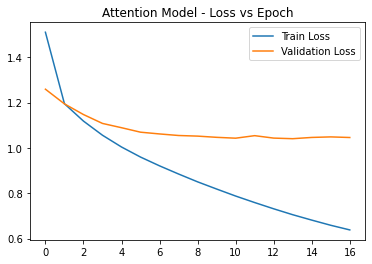

In [26]:
import matplotlib.pyplot as plt
plt.title('Attention Model - Loss vs Epoch')
plt.plot(train_loss,label= 'Train Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc="upper right")

In [17]:
model.save('Seq2Seq_attentionB_assignment2_v1.h5')